In [1]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

merged_data = pd.read_pickle('/content/drive/MyDrive/data_btc_1min.pickle')


Adding Indicators

In [3]:
merged_data['volume'] = merged_data['volume'].astype(float)
merged_data['Volatility'] = merged_data['close'].pct_change(fill_method=None).rolling(5).std().fillna(0)

# Calculate Moving Averages
merged_data['SMA_5'] = merged_data['close'].rolling(window=5).mean()
merged_data['EMA_5'] = merged_data['close'].ewm(span=5, adjust=False).mean()
merged_data['SMA_10'] = merged_data['close'].rolling(window=10).mean()
merged_data['EMA_10'] = merged_data['close'].ewm(span=10, adjust=False).mean()
merged_data['SMA_20'] = merged_data['close'].rolling(window=20).mean()
merged_data['EMA_20'] = merged_data['close'].ewm(span=20, adjust=False).mean()
merged_data['EMA_50'] = merged_data['close'].ewm(span=50, adjust=False).mean()
merged_data['SMA_100'] = merged_data['close'].rolling(window=100).mean()
merged_data['EMA_100'] = merged_data['close'].ewm(span=100, adjust=False).mean()
merged_data['EMA_200'] = merged_data['close'].ewm(span=200, adjust=False).mean()

# Calculate Bollinger Bands
merged_data['Std_20'] = merged_data['close'].rolling(window=20).std()
merged_data['Upper_BB'] = merged_data['SMA_20'] + (2 * merged_data['Std_20'])
merged_data['Lower_BB'] = merged_data['SMA_20'] - (2 * merged_data['Std_20'])
merged_data['Daily_Returns'] = 100*(merged_data['close'].pct_change())

# Add a Signal column (e.g., 1 if Close > SMA_20, else 0)
# Calculate MACD and Signal Line
# MACD Line = 12-period EMA - 26-period EMA
merged_data['EMA_12'] = merged_data['close'].ewm(span=12, adjust=False).mean()
merged_data['EMA_26'] = merged_data['close'].ewm(span=26, adjust=False).mean()
merged_data['MACD'] = merged_data['EMA_12'] - merged_data['EMA_26']

# Signal Line = 9-period EMA of MACD Line
merged_data['Signal'] = merged_data['MACD'].ewm(span=9, adjust=False).mean()

Create Target

0.9998877673416994
6.313087029411972e-05
4.9101788006537555e-05
0.5631694502704105
0.43683054972958946


<Axes: >

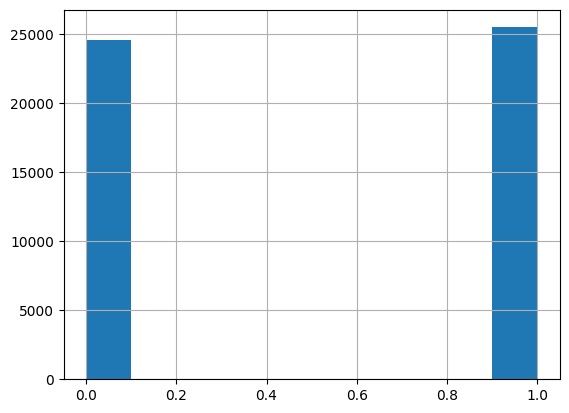

In [4]:
df = merged_data[['open', 'high', 'low', 'close', 'volume',
       'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
       'takerBuyQuoteVol', 'ignore', 'Volatility', 'SMA_5', 'EMA_5', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'EMA_50', 'SMA_100', 'EMA_100', 'EMA_200',
       'Std_20', 'Upper_BB', 'Lower_BB', 'Daily_Returns', 'EMA_12', 'EMA_26',
       'MACD', 'Signal']].copy()


for x in df.columns:
  df[x] = df[x].astype(float)

list_cols = df.columns

df['prev_return'] = 100*((df['close']-df['close'].shift(1))/df['close'])
df['return'] = 100*df['close'].pct_change()
df['volatility'] = 10*df['return'].rolling(30).std().shift(-30)
# df['return'] = ((df['close'].shift(-1)-df['close'])/df['close'])
df
# df['return'] = (df['volume'].shift(1)+df['volume'].shift(2)+df['volume'].shift(3))
# df['return'] = df['return']-df['return'].mean()
# df['return'] = df['return']/df['return'].std()

# df['return'] = 100*(df['close'].shift(-1440*2)-df['close'])/df['close']

for x in list_cols:
  tmp = df[x]-df[x].mean()
  df[x] = tmp/tmp.std()

# df['return'] = (df['volume'].shift(1)+df['volume'].shift(2)+df['volume'].shift(3))
# df['return'] = (df['volume'].shift(1)-df['volume'].shift(2))
# df['return'] = 20*(df['close'].shift(1)-df['close'].shift(2))
# df['return'] = 20*(df['close'].shift(-1)-df['close'])
# df['return'] = 100*(df['close'].shift(-5)-df['close'])/df['close']

# df['return1'] = abs(100*((df['high'].rolling(5).max().shift(-5)-df['close'])/df['close']))
# df['return2'] = abs(100*((df['low'].rolling(5).min().shift(-5)-df['close'])/df['close']))
# df['return'] = df[['return1', 'return2']].max(axis=1)

# df['return'] = 10*df['close'].rolling(15).std().shift(-15)


# df['return'] = 100*(df['close'].shift(-1440*3)-df['close'])/df['close']
# df['return'] = 100*(df['close'].shift(-1440*3)-df['close'])


# df['return'] = ((df['volume'].shift(2)-df['volume'].shift(3))/df['volume'].shift(3))
# df['return'] = (100*((df['close'].shift(-1440*7)-df['close'])/df['close'])).fillna(0)
# df['return'] = 100*((df['volume'].shift(2)-df['volume'].shift(3))/df['volume'].shift(3))
# df['return'] = (1*((df['volume'].shift(-1440)-df['volume'])/df['volume'])).fillna(0)
# df['return2'] = (100*((df['close'].shift(-1)-df['close'])/df['close'])).fillna(0)


df = df.fillna(0)

threshold = 1
df['return_class'] = 0
df.loc[df['return']>threshold, 'return_class'] = 1
df.loc[df['return']<-threshold, 'return_class'] = 2

print((df['return_class']==0).sum()/len(df))
print((df['return_class']==1).sum()/len(df))
print((df['return_class']==2).sum()/len(df))

threshold = 0.52
df['return_class'] = 0
df.loc[abs(df['volatility'])>threshold, 'return_class'] = 1
# df.loc[df['return']<-threshold, 'return_class'] = 2

print((df['return_class']==0).sum()/len(df))
print((df['return_class']==1).sum()/len(df))
# print((df['return_class']==2).sum()/len(df))

df.iloc[:50000]['return_class'].hist()

In [5]:
features = ['open', 'high', 'low', 'close', 'volume',
       'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
       'takerBuyQuoteVol', 'ignore', 'Volatility', 'SMA_5', 'EMA_5', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'EMA_50', 'SMA_100', 'EMA_100', 'EMA_200',
       'Std_20', 'Upper_BB', 'Lower_BB', 'Daily_Returns', 'EMA_12', 'EMA_26',
       'MACD', 'Signal', 'prev_return']

selected_f_all = features


Model Architecture

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft

configs = {
    'task_name': 'classification',
    'seq_len': 96,
    'enc_in': len(features),
    'd_model': 64,
    'd_ff': 128,
    'num_kernels': 3,
    'dropout': 0.1,
    'e_layers': 2,
    'top_k': 2,
    'num_class': 3
}


# Minimal versions of needed modules
class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=3):
        super().__init__()
        kernel_sizes = [3, 5, 7][:num_kernels]
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=k // 2)
            for k in kernel_sizes
        ])
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = sum(conv(x) for conv in self.convs) / len(self.convs)
        return self.bn(out)

class DataEmbedding(nn.Module):
    def __init__(self, input_dim, model_dim, embed_type='fixed', freq='h', dropout=0.1):
        super().__init__()
        self.value_embedding = nn.Linear(input_dim, model_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark_enc=None):
        x = self.value_embedding(x)
        return self.dropout(x)

def FFT_for_Period(x, k=2):
    xf = torch.fft.rfft(x, dim=1)
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]

class TimesBlock(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs['seq_len']
        self.k = configs['top_k']
        self.conv = nn.Sequential(
            Inception_Block_V1(configs['d_model'], configs['d_ff'], num_kernels=configs['num_kernels']),
            nn.GELU(),
            Inception_Block_V1(configs['d_ff'], configs['d_model'], num_kernels=configs['num_kernels'])
        )

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)
        res = []
        for i in range(self.k):
            period = period_list[i]
            length = self.seq_len
            if length % period != 0:
                pad_len = ((length // period) + 1) * period - length
                x_padded = torch.cat([x, torch.zeros(B, pad_len, N).to(x.device)], dim=1)
            else:
                x_padded = x
            out = x_padded.reshape(B, -1, period, N).permute(0, 3, 1, 2).contiguous()
            out = self.conv(out)
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :self.seq_len, :])
        res = torch.stack(res, dim=-1)
        period_weight = F.softmax(period_weight, dim=1).unsqueeze(1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        return res + x

class TimesNetClassifier(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs['seq_len']
        self.enc_embedding = DataEmbedding(configs['enc_in'], configs['d_model'], dropout=configs['dropout'])
        self.layers = nn.ModuleList([TimesBlock(configs) for _ in range(configs['e_layers'])])
        self.norm = nn.LayerNorm(configs['d_model'])
        self.act = F.gelu
        self.dropout = nn.Dropout(configs['dropout'])
        self.projection = nn.Linear(configs['d_model'] * configs['seq_len'], configs['num_class'])

    def forward(self, x, x_mask=None):
        x = self.enc_embedding(x)
        for layer in self.layers:
            x = self.norm(layer(x))
        x = self.act(x)
        x = self.dropout(x)
        if x_mask is not None:
            x = x * x_mask.unsqueeze(-1)
        x = x.reshape(x.shape[0], -1)
        return self.projection(x)


class TimesNetBackbone(nn.Module):
    def __init__(self, configs, embedding_dim=512):
        super().__init__()
        self.seq_len = configs['seq_len']
        self.enc_embedding = DataEmbedding(configs['enc_in'], configs['d_model'], dropout=configs['dropout'])
        self.layers = nn.ModuleList([TimesBlock(configs) for _ in range(configs['e_layers'])])
        self.norm = nn.LayerNorm(configs['d_model'])
        self.act = F.gelu
        self.dropout = nn.Dropout(configs['dropout'])
        self.embedding_proj = nn.Linear(configs['d_model'] * configs['seq_len'], embedding_dim)

    def forward(self, x, x_mask=None):
        x = self.enc_embedding(x)
        for layer in self.layers:
            x = self.norm(layer(x))
        x = self.act(x)
        x = self.dropout(x)
        if x_mask is not None:
            x = x * x_mask.unsqueeze(-1)
        x = x.reshape(x.shape[0], -1)  # flatten
        embedding = self.embedding_proj(x)  # shape: [B, embedding_dim]
        return embedding

class CombinedClassifier(nn.Module):
    def __init__(self, backbone, extra_vector_dim, num_classes):
        super().__init__()
        self.backbone = backbone
        total_dim = 512 + extra_vector_dim
        self.classifier = nn.Linear(total_dim, num_classes)

    def forward(self, x, x_mask, extra_vector):
        emb = self.backbone(x, x_mask)  # [B, 512]
        # print(emb.shape)
        combined = torch.cat([emb, extra_vector], dim=-1)  # [B, 512 + extra_dim]
        return self.classifier(combined)


configs['d_model'] = 64  # typical
backbone = TimesNetBackbone(configs, embedding_dim=512)
model = CombinedClassifier(backbone, extra_vector_dim=10, num_classes=3)

x = torch.randn(32, configs['seq_len'], configs['enc_in'])      # input
mask = torch.ones(32, configs['seq_len'])                       # mask
extra = torch.randn(32, 10)                                     # extra features
out = model(x, mask, extra)                                     # classification output
print(out.shape)  # [32, 3]



torch.Size([32, 3])


In [7]:
configs

{'task_name': 'classification',
 'seq_len': 96,
 'enc_in': 30,
 'd_model': 64,
 'd_ff': 128,
 'num_kernels': 3,
 'dropout': 0.1,
 'e_layers': 2,
 'top_k': 2,
 'num_class': 3}

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft

# Minimal versions of needed modules
class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=3):
        super().__init__()
        kernel_sizes = [3, 5, 7][:num_kernels]
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=k // 2)
            for k in kernel_sizes
        ])
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = sum(conv(x) for conv in self.convs) / len(self.convs)
        return self.bn(out)

class DataEmbedding(nn.Module):
    def __init__(self, input_dim, model_dim, embed_type='fixed', freq='h', dropout=0.1):
        super().__init__()
        self.value_embedding = nn.Linear(input_dim, model_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark_enc=None):
        x = self.value_embedding(x)
        return self.dropout(x)

def FFT_for_Period(x, k=2):
    xf = torch.fft.rfft(x, dim=1)
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]

class TimesBlock(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs['seq_len']
        self.k = configs['top_k']
        self.conv = nn.Sequential(
            Inception_Block_V1(configs['d_model'], configs['d_ff'], num_kernels=configs['num_kernels']),
            nn.GELU(),
            Inception_Block_V1(configs['d_ff'], configs['d_model'], num_kernels=configs['num_kernels'])
        )

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)
        res = []
        for i in range(self.k):
            period = period_list[i]
            length = self.seq_len
            if length % period != 0:
                pad_len = ((length // period) + 1) * period - length
                x_padded = torch.cat([x, torch.zeros(B, pad_len, N).to(x.device)], dim=1)
            else:
                x_padded = x
            out = x_padded.reshape(B, -1, period, N).permute(0, 3, 1, 2).contiguous()
            out = self.conv(out)
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :self.seq_len, :])
        res = torch.stack(res, dim=-1)
        period_weight = F.softmax(period_weight, dim=1).unsqueeze(1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        return res + x

class TimesNetClassifier(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.seq_len = configs['seq_len']
        self.enc_embedding = DataEmbedding(configs['enc_in'], configs['d_model'], dropout=configs['dropout'])
        self.layers = nn.ModuleList([TimesBlock(configs) for _ in range(configs['e_layers'])])
        self.norm = nn.LayerNorm(configs['d_model'])
        self.act = F.gelu
        self.dropout = nn.Dropout(configs['dropout'])
        self.projection = nn.Linear(configs['d_model'] * configs['seq_len'], configs['num_class'])

    def forward(self, x, x_mask=None):
        x = self.enc_embedding(x)
        for layer in self.layers:
            x = self.norm(layer(x))
        x = self.act(x)
        x = self.dropout(x)
        if x_mask is not None:
            x = x * x_mask.unsqueeze(-1)
        x = x.reshape(x.shape[0], -1)
        return self.projection(x)

# Example configuration for classification
# configs = {
#     'task_name': 'classification',
#     'seq_len': args.seq_len,
#     'enc_in': args.enc_in,         # number of input features
#     'd_model': args.d_model,
#     'd_ff': args.d_ff,
#     'num_kernels': args.num_kernels,
#     'dropout': 0.1,
#     'e_layers': args.e_layers,
#     'top_k': args.top_k,
#     'num_class': args.num_class       # number of classes
# }

# Instantiate and print model
model = TimesNetClassifier(configs)
print(model)

# # Dummy input
x = torch.randn(32, configs['seq_len'], configs['enc_in'])  # [batch, time, features]
x_mask = torch.ones(32, configs['seq_len'])                 # [batch, time]
output = model(x, x_mask)
print("Output shape:", output.shape)  # should be [32, num_class]


TimesNetClassifier(
  (enc_embedding): DataEmbedding(
    (value_embedding): Linear(in_features=30, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layers): ModuleList(
    (0-1): 2 x TimesBlock(
      (conv): Sequential(
        (0): Inception_Block_V1(
          (convs): ModuleList(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          )
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Inception_Block_V1(
          (convs): ModuleList(
            (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (2): Conv2d(128, 64, kernel_s

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TimesNetClassifier(configs).to(device)


Dataset and Dataloader

In [10]:
import torch
from torch import nn, optim
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset

class ReturnClassDataset(Dataset):
    def __init__(self, df, seq_len=96, features=None):
        if features is None:
            features = ['open', 'high', 'low', 'close', 'volume', 'return']
        self.seq_len = seq_len
        self.features = features

        features = df[features].values  # all columns except last (assumed target)
        targets = df['return_class'].values    # last column is the target

        # Create input (X) and label (y)
        X = []
        y = []
        for i in range(len(df) - seq_len):
            X.append(features[i:i+seq_len])
            y.append(targets[i + seq_len-1])

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        x_mask = torch.ones(x.shape[0])
        return x, x_mask, self.y[idx]


# from dataset import generate_fake_ohlcv_dataset, ReturnClassDataset
# from model import TimesNetClassifier  # assuming you save model in model.py
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


df_scaled = df.iloc[:50000].fillna(0)
split = int(0.8 * len(df_scaled))
df_train = df_scaled.iloc[:split]
df_val = df_scaled.iloc[split:]

train_dataset = ReturnClassDataset(df_train, seq_len=configs['seq_len'], features=features)
val_dataset = ReturnClassDataset(df_val, seq_len=configs['seq_len'], features=features)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Load and Train Model

In [11]:
# Model
model = TimesNetClassifier(configs).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Early stopping setup
best_val_acc = 0.0
epochs_no_improve = 0
patience = 5
best_model_state = None
early_stop = False

num_epochs = 50  # allow more epochs to benefit from early stopping

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x, mask, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        x, mask, y = x.to(device), mask.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x, mask)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, mask, y in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            x, mask, y = x.to(device), mask.to(device), y.to(device)
            output = model(x, mask)
            loss = criterion(output, y)
            val_losses.append(loss.item())
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    val_acc = accuracy_score(all_targets, all_preds)

    print(f"\nEpoch {epoch+1}: Train Loss = {sum(train_losses)/len(train_losses):.4f}, "
          f"Val Loss = {sum(val_losses)/len(val_losses):.4f}, "
          f"Val Acc = {val_acc:.4f}")
    print("Classification Report:\n", classification_report(all_targets, all_preds, target_names=['Natural', 'Up']))

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs. Best Val Acc = {best_val_acc:.4f}")
        early_stop = True
        break

# Load best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)



Epoch 1 Validation: 100%|██████████| 310/310 [00:02<00:00, 121.59it/s]



Epoch 1: Train Loss = 0.3177, Val Loss = 0.5099, Val Acc = 0.8164
Classification Report:
               precision    recall  f1-score   support

     Natural       0.47      0.43      0.45      1737
          Up       0.88      0.90      0.89      8167

    accuracy                           0.82      9904
   macro avg       0.68      0.67      0.67      9904
weighted avg       0.81      0.82      0.81      9904



Epoch 2 Validation: 100%|██████████| 310/310 [00:02<00:00, 130.13it/s]



Epoch 2: Train Loss = 0.2791, Val Loss = 0.7874, Val Acc = 0.7837
Classification Report:
               precision    recall  f1-score   support

     Natural       0.23      0.10      0.14      1737
          Up       0.83      0.93      0.88      8167

    accuracy                           0.78      9904
   macro avg       0.53      0.51      0.51      9904
weighted avg       0.72      0.78      0.75      9904



Epoch 3 Validation: 100%|██████████| 310/310 [00:02<00:00, 130.48it/s]



Epoch 3: Train Loss = 0.2602, Val Loss = 0.6829, Val Acc = 0.8081
Classification Report:
               precision    recall  f1-score   support

     Natural       0.40      0.19      0.26      1737
          Up       0.84      0.94      0.89      8167

    accuracy                           0.81      9904
   macro avg       0.62      0.56      0.57      9904
weighted avg       0.77      0.81      0.78      9904



Epoch 4 Validation: 100%|██████████| 310/310 [00:02<00:00, 131.64it/s]



Epoch 4: Train Loss = 0.2378, Val Loss = 0.9287, Val Acc = 0.7844
Classification Report:
               precision    recall  f1-score   support

     Natural       0.32      0.21      0.26      1737
          Up       0.84      0.91      0.87      8167

    accuracy                           0.78      9904
   macro avg       0.58      0.56      0.56      9904
weighted avg       0.75      0.78      0.77      9904



Epoch 5 Validation: 100%|██████████| 310/310 [00:02<00:00, 127.61it/s]



Epoch 5: Train Loss = 0.2169, Val Loss = 0.9520, Val Acc = 0.7919
Classification Report:
               precision    recall  f1-score   support

     Natural       0.27      0.11      0.16      1737
          Up       0.83      0.94      0.88      8167

    accuracy                           0.79      9904
   macro avg       0.55      0.52      0.52      9904
weighted avg       0.73      0.79      0.75      9904



Epoch 6 Validation: 100%|██████████| 310/310 [00:02<00:00, 130.19it/s]



Epoch 6: Train Loss = 0.1914, Val Loss = 0.7796, Val Acc = 0.7951
Classification Report:
               precision    recall  f1-score   support

     Natural       0.42      0.42      0.42      1737
          Up       0.88      0.88      0.88      8167

    accuracy                           0.80      9904
   macro avg       0.65      0.65      0.65      9904
weighted avg       0.80      0.80      0.80      9904


Early stopping triggered after 6 epochs. Best Val Acc = 0.8164
